In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

In [2]:
Data = pd.read_csv('Airbnbprediction.csv')
# Suppression des colonnes
to_deleted =['id','description', 'first_review', 'host_has_profile_pic', 'host_identity_verified', 
    'host_response_rate', 'host_since', 'last_review', 'latitude', 'longitude', 'name',
    'number_of_reviews', 'review_scores_rating', 'thumbnail_url', 'zipcode', 'instant_bookable']
Data.drop(to_deleted, axis=1, inplace=True)
# Modification des log_price
Data['log_price']=Data['log_price'].apply(lambda x : math.exp(x))
Data.rename(columns={'log_price' : 'price'}, inplace=True)

In [35]:
Data.describe()

,price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,bedrooms,beds
count,64252.000000,64252.000000,64252.000000,64252.000000,64252.000000,64252.000000,64252.000000,64252.000000,64252.000000,64252.000000
mean,138.608993,0.999666,0.999986,0.999821,0.999777,1.000425,1.000078,1.000005,0.999823,1.000148
std,92.062984,0.071988,0.354305,0.639050,0.400811,0.061057,0.098280,0.073863,0.629809,0.679948
min,20.000000,0.430000,0.456000,0.332000,0.000000,0.613000,0.898000,0.876000,0.000000,0.000000
25%,75.000000,0.974000,0.616000,0.664000,0.842000,1.011000,0.898000,0.876000,0.827000,0.612000
50%,110.000000,0.974000,1.318000,0.664000,0.842000,1.011000,0.941000,1.044000,0.827000,0.612000
75%,175.000000,1.032000,1.318000,1.329000,0.842000,1.011000,1.103000,1.044000,0.827000,1.224000
max,500.000000,1.738000,1.318000,5.315000,6.739000,1.011000,1.809000,1.044000,8.272000,9.789000


In [3]:
Data=Data[(Data['price']>20) & (Data['price']<500)]
Data.drop_duplicates(inplace=True)

In [4]:
Dt=Data.groupby(['property_type'])['price'].mean()>200
Timeshare=Dt[Dt==True].index
Data['property_type']=Data['property_type'].apply(lambda x : 'Timeshare' if x in Timeshare else x)
# Selection des types de propriétés à supprimer
Dt=Data['property_type'].value_counts()<=50
to_deleted=Dt[Dt==True].index
# Suppression des types de propriétés sélectionnés.
Data=Data[Data['property_type'].isin(to_deleted)==False]

In [5]:
Data.dropna(how='any', axis=0, inplace=True)

In [6]:
# Sauvegarde des données originales
Data_originale = Data.copy()

In [7]:
# Représentation des types de chambre en fonction des prix moyens
PrixM=Data['price'].mean()
Dt=pd.DataFrame(Data.groupby(['room_type'])['price'].mean()/PrixM)
Data['room_type']=Data['room_type'].apply(lambda x : round(Dt.loc[x]['price'],3))

In [8]:
PrixM=Data['price'].mean()
Dt=pd.DataFrame(Data.groupby(['bed_type'])['price'].mean()/PrixM)
Data['bed_type']=Data['bed_type'].apply(lambda x : round(Dt.loc[x]['price'],3))

In [9]:
super_strict = ['super_strict_30', 'super_strict_60']
Data['cancellation_policy']=Data['cancellation_policy'].apply(lambda x : 'super_strict' if x in super_strict else x)

In [10]:
# Modification des annulation en fonction de leur rapport
PrixM=Data['price'].mean()
Dt=pd.DataFrame(Data.groupby(['cancellation_policy'])['price'].mean()/PrixM)
Data['cancellation_policy']=Data['cancellation_policy'].apply(lambda x : round(Dt.loc[x]['price'],3))

In [11]:
# Modification des types de propriétés en fonction de leur rapport
PrixM=Data['price'].mean()
Dt=pd.DataFrame(Data.groupby(['property_type'])['price'].mean()/PrixM)
Data['property_type']=Data['property_type'].apply(lambda x : round(Dt.loc[x]['price'],3))

In [12]:
# Afin d'avoir des données comparables nous allons normaliser les features 
# accommodate, bathrooms, bedrooms et beds
Means=Data['accommodates'].mean()
Data['accommodates']=Data['accommodates'].apply(lambda x : round(x/Means,3))
Means=Data['bathrooms'].mean()
Data['bathrooms']=Data['bathrooms'].apply(lambda x : round(x/Means,3))
Means=Data['bedrooms'].mean()
Data['bedrooms']=Data['bedrooms'].apply(lambda x : round(x/Means,3))
Means=Data['beds'].mean()
Data['beds']=Data['beds'].apply(lambda x : round(x/Means,3))

In [13]:
Dt=pd.DataFrame(Data.groupby(['cleaning_fee'])['price'].mean())
Dt['counts']=Data['cleaning_fee'].value_counts()
Dt

,price,counts
cleaning_fee,,
False,121.441162,16826
True,144.699869,47426


In [14]:
PrixM=Data['price'].mean()
Dt=pd.DataFrame(Data.groupby(['cleaning_fee'])['price'].mean()/PrixM)
Data['cleaning_fee']=Data['cleaning_fee'].apply(lambda x : round(Dt.loc[x]['price'],3))

In [15]:
def aminities_list(df) :
    amenities = set()
    for line in df['amenities'] :
        for word in line.split(',') :
            if len(word.strip())>0 :
                amenities.add(word.strip())
    return list(amenities)

In [16]:
def encodage(df) :
    df['amenities']=df['amenities'].apply(lambda x : re.sub(r'[\"÷\{\}]','',x))
    aminities = aminities_list(df)
    to_replace_ = list(['Doorman Entry', 'Elevator in building', 'Internet', 'Firm matress', 
                'Other pet(s)', 'Smart lock', 'Wide clearance to bed', 'Wide clearance to shower & toilet',
                'Wide clearance to shower and toilet', 'translation missing: en.hosting_amenity_49',
                'translation missing: en.hosting_amenity_50', 'Waterfront'])
    replace_ = list(['Doorman', 'Elevator', 'Ethernet connection', 'Firm mattress',
                'Pets allowed', 'Smartlock', 'Wide clearance', 'Wide clearance', 
                'Wide clearance', 'translation missing',
                'translation missing', 'Beachfront'])
    df['amenities'].replace(to_replace=to_replace_, value=replace_, regex=True, inplace=True)
    aminities = aminities_list(df)
    for amenitie in aminities :
        dumies = pd.DataFrame([1 if amenitie in s.split(',') else 0 
                    for s in df['amenities']], index=df.index, columns=[amenitie])
        df=pd.concat([df, dumies], axis=1)
    #df.drop(['amenities'], axis=1, inplace=True)
    return df, aminities

In [17]:
Data_test = Data.copy()

In [18]:
df , amenities = encodage(Data_test)

C:\Users\matth\AppData\Local\Temp\ipykernel_24376\1975779447.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['amenities'].replace(to_replace=to_replace_, value=replace_, regex=True, inplace=True)


In [19]:
df_save = df.copy()

In [20]:
df.select_dtypes("object")

,amenities,city,neighbourhood
0,"Wireless Ethernet connection,Air conditioning,...",NYC,Brooklyn Heights
1,"Wireless Ethernet connection,Air conditioning,...",NYC,Hell's Kitchen
2,"TV,Cable TV,Wireless Ethernet connection,Air c...",NYC,Harlem
4,"TV,Ethernet connection,Wireless Ethernet conne...",DC,Columbia Heights
5,"TV,Wireless Ethernet connection,Heating,Smoke ...",SF,Noe Valley
...,...,...,...
74106,,NYC,Williamsburg
74107,"TV,Cable TV,Ethernet connection,Wireless Ether...",LA,Hermosa Beach
74108,"TV,Ethernet connection,Wireless Ethernet conne...",NYC,Williamsburg
74109,"TV,Wireless Ethernet connection,Air conditioni...",NYC,West Village


In [21]:
df.drop(['amenities', 'city', 'neighbourhood'], axis=1, inplace=True)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df.drop("price",axis=1), df['price'], test_size=0.2, random_state=0)

In [23]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, Y_train)

DecisionTreeRegressor()

In [24]:
Y_pred = model.predict(X_test)

In [25]:
model.score(X_test, Y_test)

-0.026419769333939636

In [26]:
from sklearn.model_selection import cross_val_score
scores=[]
for n in range(1,50):
    model = DecisionTreeRegressor(max_depth=n, random_state=0)
    scores.append(cross_val_score(model, X_train, Y_train, cv=10))

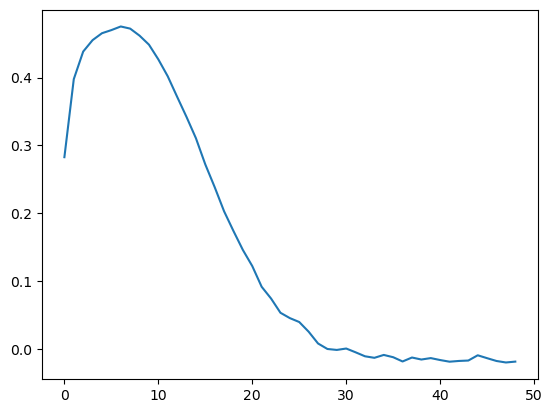

In [27]:
plt.plot([x.mean() for x in scores])

In [28]:
model=DecisionTreeRegressor(max_depth=9, random_state=0)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
model.score(X_test, Y_test)

0.46239765344629313

In [29]:
importance = pd.DataFrame(data=model.feature_importances_, index=X_test.columns, columns=['%'])
importance.sort_values(by='%', ascending=False)[:20]

,%
room_type,0.532991
bathrooms,0.225010
bedrooms,0.078900
accommodates,0.030182
Elevator,0.020113
property_type,0.012406
Doorman,0.009563
Free parking on premises,0.008505
Indoor fireplace,0.007966
Cable TV,0.007775


In [30]:
from sklearn.model_selection import validation_curve
train_score, test_score = validation_curve(DecisionTreeRegressor(), X_train, Y_train, param_name='max_depth', 
                                           param_range=np.arange(1,50), cv=5)

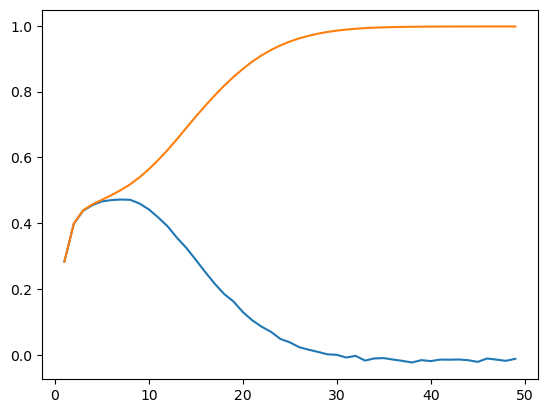

In [31]:
plt.plot(np.arange(1,50), test_score.mean(axis=1), label='valSet')
plt.plot(np.arange(1,50), train_score.mean(axis=1), label='trainSet')

In [32]:
df_save.columns

Index(['price', 'property_type', 'room_type', 'amenities', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       ...
       'BBQ grill', 'Ground floor access', 'Smartlock', 'Private bathroom',
       'Well-lit path to entrance', 'Stove', 'Wide clearance',
       'Cooking basics', 'Grab-rails for shower and toilet', 'Other pet(s)'],
      dtype='object', length=134)

In [33]:
df.select_dtypes('object')

""
0
1
2
4
5
...
74106
74107
74108
74109
